In [1]:
import tensorflow as tf 
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
from pandas import read_csv
from datetime import datetime
# load data
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
dataset = read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv',  parse_dates = [1], index_col=0, date_parser=parser)

dataset = dataset.set_index('Date')
dataset.columns = ['counts', 'speed']
# summarize first 5 rows
print(dataset.head(5))

            counts   speed
Date                      
2020-01-01   394.0  1.1506
2020-01-02   397.0  1.1504
2020-01-03   382.0  1.1563
2020-01-04   395.0  1.1561
2020-01-05   394.0  1.1540


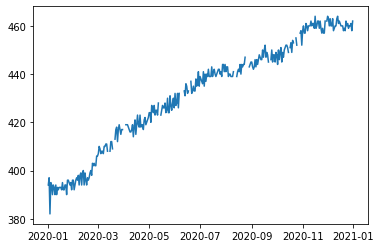

In [29]:
plt.plot(dataset.counts)

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
# load dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
dataset = read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv',  parse_dates = [1], index_col=0, date_parser=parser)

dataset = dataset.set_index('Date')
dataset.columns = ['counts', 'speed']

cols = ['counts', 'speed']
dataset = dataset.loc[dataset.index, cols]
dataset = dataset.interpolate()
dataset.head(5)

,counts,speed
Date,,
2020-01-01,394.0,1.1506
2020-01-02,397.0,1.1504
2020-01-03,382.0,1.1563
2020-01-04,395.0,1.1561
2020-01-05,394.0,1.1540


In [5]:
trend = read_csv('/content/trend_speed.csv')

In [9]:
trend.head(5)

,Unnamed: 0,trend_speed
0,0,392.038602
1,1,391.828795
2,2,391.516005
3,3,391.797150
4,4,391.822646


In [17]:
dataset.counts[0:274] = trend.trend_speed

In [18]:
dataset.head(5)

,counts,speed
Date,,
2020-01-01,392.038602,1.1506
2020-01-02,391.828795,1.1504
2020-01-03,391.516005,1.1563
2020-01-04,391.797150,1.1561
2020-01-05,391.822646,1.1540


In [19]:
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,0] = encoder.fit_transform(values[:,0])
# # ensure all data is float 
# values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [20]:
# specify the number of lag days
n_hours = 3
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train = 274
train = values[:n_train, :]
test = values[n_train:, :]

(363, 8)


In [21]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, 7]
test_X, test_y = test[:, :n_obs], test[:, 7]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(274, 6) 274 (274,)
(274, 3, 2) (274,) (89, 3, 2) (89,)


Epoch 1/100
4/4 - 3s - loss: 0.3580 - val_loss: 0.7999 - 3s/epoch - 711ms/step
Epoch 2/100
4/4 - 0s - loss: 0.2999 - val_loss: 0.7016 - 45ms/epoch - 11ms/step
Epoch 3/100
4/4 - 0s - loss: 0.2425 - val_loss: 0.6013 - 48ms/epoch - 12ms/step
Epoch 4/100
4/4 - 0s - loss: 0.1863 - val_loss: 0.4979 - 41ms/epoch - 10ms/step
Epoch 5/100
4/4 - 0s - loss: 0.1310 - val_loss: 0.3913 - 49ms/epoch - 12ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0874 - val_loss: 0.2878 - 51ms/epoch - 13ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0573 - val_loss: 0.1912 - 49ms/epoch - 12ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0571 - val_loss: 0.1283 - 46ms/epoch - 12ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0703 - val_loss: 0.1196 - 49ms/epoch - 12ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0644 - val_loss: 0.1506 - 43ms/epoch - 11ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0555 - val_loss: 0.1812 - 40ms/epoch - 10ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0519 - val_loss: 0.1856 - 47ms/epoch - 12ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0468 -

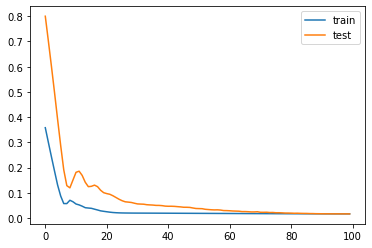

In [22]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction counts
yhat = model.predict(test_X)
test_Xc = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_Xc[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_Xc[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [24]:
counts_y = inv_y[:,0]
counts_yhat = inv_yhat[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(counts_y, counts_yhat))
print('Test RMSE: %.6f' % rmse)

Test RMSE: 1.442477


In [25]:
counts_y = inv_y[:,0]
counts_yhat = inv_yhat[:,0]
# calculate MAE
mae = mean_absolute_error(counts_y, counts_yhat)
print('Test MAE: %.6f' % mae)

Test MAE: 1.172822


In [26]:
counts_y = inv_y[:,0]
counts_yhat = inv_yhat[:,0]
# calculate MAPE
mape = mean_absolute_percentage_error(counts_y, counts_yhat)
print('Test MAPE: %.6f' % mape)

Test MAPE: 0.002598


In [265]:
# make a prediction counts
yhat = model.predict(test_X)
test_Xc = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_Xc[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_Xc[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [236]:
speed_y = inv_y[:,1]
speed_yhat = inv_yhat[:,1]
# calculate RMSE
rmse = sqrt(mean_squared_error(speed_y, speed_yhat)**0.5)
print('Test RMSE: %.6f' % rmse)

Test RMSE: 0.202362


In [237]:
speed_y = inv_y[:,0]
speed_yhat = inv_yhat[:,0]
# calculate MAE
mae = sqrt(mean_absolute_error(speed_y, speed_yhat))
print('Test MAE: %.6f' % mae)

Test MAE: 193.503791


In [ ]:
speed_y = inv_y[:,0]
speed_yhat = inv_yhat[:,0]
# calculate MAPE
mape = sqrt(mean_absolute_percentage_error(speed_y, speed_yhat))
print('Test MAE: %.6f' % mape)